In [50]:
import networkx as nx
import pandas as pd

import network_example as ne
import graph_utils as gu
import matplotlib.pyplot as plt
import optimize as ogf
import model as m
from bike_visualizations import animate_bike_distribution, station_bike_hist

# Metrobike Simulation
Our simulation of the Metrobike system follows a few basic ideas:
- On the map, we hve destinations, where commuters want to go, and stations, where they can pick up or drop off bikes.
- Each station starts out with a certain number of bikes and a maximum capacity.
- Commuters travel to and from destinations, and can stop at stations to pick up or drop off bikes. Their choice of destination is based on a probability distribution.
- A commuter can only rent a bike from a station if there are any available, and must park the bike at a station before they reach their destination.
- Commuters have access to map data: distances between stations, destination, and the availability of bikes/parking spots at each station.
- At each time step, commuters move towards their selected destination by using a pathfinding algorithm that chooses the shortest path while comparing biking and walking times.

## Basic Simulation
First, we will show an example of a basic simulation without any optimization.

### Map and Station Data
Here, the map has a simple layout of 4 destinations at the vertices of a rectangle, and 4 stations at the vertices of a smaller rectangle. This example was used extensively in testing the ABM simulation, so we created a file `network_example.py` to conveniently load the map and station data. Later, we will use custom maps and station data to simulate the Metrobike system in Austin, Texas.

The `ne.basic_graph()` function found in the `network_example.py` file creates the simple graph with 4 destinations and 4 stations, and each station has a max capcity of 5 bikes and starts out with 3 bikes each.

Station 0 has 3 bikes
Station 1 has 3 bikes
Station 2 has 3 bikes
Station 3 has 3 bikes


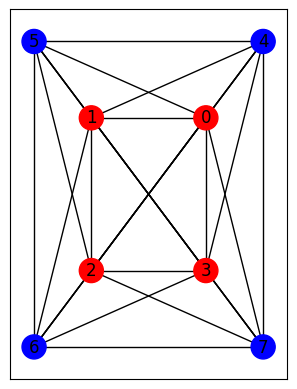

In [51]:
n_stations = 4
G, total_nodes = ne.basic_graph()
pos = {i: total_nodes[i] for i in range(total_nodes.shape[0])}
colors = ['b' if G.nodes[i]['type'] == 'destination' else 'r' for i in G.nodes]
nx.draw_networkx(G, pos, node_color=colors, with_labels=True)
plt.gca().set_aspect('equal', adjustable='box')
# print the number of bikes at each station
for i in range(n_stations):
    print('Station', i, 'has', G.nodes[i]['data'].available_bikes, 'bikes')

### Adjusting the initial conditions and map parameters
We can adjust the basic graph simulation in a few ways:
- Change the capacity of the stations to hold a maximum of 10 bikes each.
- Change the bike distribution at the start of the simulation to have 10 bikes at station 0, and 0 bikes at the other stations.

### Running the simulation
When we run the simulation, we need to take into account the following additional parameters:
- The number of time steps to run the simulation for.
- The number of commuters to simulate.
- The probability distribution of destinations for the commuters.

The popularity of each destination will be determined by the weights, which are the probabilities of each destination being chosen for a commuter to travel to. In this example, we will assume that destination 4 has a probability of 0.7, and the other destinations have a probability of 0.1 each.

The output dataframe will show each agent's pathfinding decisions, the distance left in its journey, the number of bikes at each station, and whether or not the agent is currently riding a bike

In [52]:
g = ne.basic_graph(capacity=10)[0]

bike_distribution = {
    0:10,
    1:0,
    2:0,
    3:0
}

weights = [
    0.7,
    0.1,
    0.1,
    0.1
]

model = m.MyModel(100, seed=2, G=g, bike_init=bike_distribution, weights=weights)
for i in range(1000):
    model.step()

agent_data = model.datacollector.get_agent_vars_dataframe()
pd.reset_option('display.max_rows', None)
agent_data[['Distance_Left', "Position", 'Intermediate_Node', 'Destination', 'All Station Capacity', 'Biking', 'Park Failures']]

Distance_Left  Position  Intermediate_Node  Destination  \
Step AgentID                                                            
0    1            15.000000         4                  0            6   
     2            36.000000         4                  5            5   
     3            15.000000         4                  0            7   
     4            60.000000         6                  4            4   
     5            36.000000         5                  4            4   
...                     ...       ...                ...          ...   
1000 96           27.000000         4                  7            7   
     97            1.000000         7                  4            4   
     98           12.107951         0                  7            7   
     99            1.000000         2                  4            4   
     100          35.000000         7                  4            4   

                   All Station Capacity  Biking  Park Failures  
Step AgentID                                                    
0    1        {0: 10, 1: 0, 2: 0, 3: 0}   False              0  
     2        {0: 10, 1: 0, 2: 0, 3: 0}   False              0  
     3        {0: 10, 1: 0, 2: 0, 3: 0}   False              0  
     4        {0: 10, 1: 0, 2: 0, 3: 0}   False              0  
     5        {0: 10, 1: 0, 2: 0, 3: 0}   False              0  
...                                 ...     ...            ...  
1000 96        {0: 1, 1: 2, 2: 0, 3: 0}   False              0  
     97        {0: 1, 1: 2, 2: 0, 3: 0}   False              0  
     98        {0: 1, 1: 2, 2: 0, 3: 0}   False              0  
     99        {0: 1, 1: 2, 2: 0, 3: 0}   False              0  
     100       {0: 1, 1: 2, 2: 0, 3: 0}   False              0  

[100100 rows x 7 columns]

### Visualization of the simulation
We found it helpful to visualize the distribution of the number of bikes at each station over time. This can help us understand which stations are the most popular and see if there are any patterns in the distribution of bikes.

In our example, we see that station 0 is the most popular since it has a fairly heavy tail towards 10 bikes (which is all the bikes in the whole map). This is expected since it is the station that is the closes to the most popular destination. But also, we see that station 2 is also fairly popular, which is interesting since it is the furthest station from the most popular destination. This likely happened because for a commuter to travel from destination 4 to destination 5 or even destination 7, the time it takes to walk directly to the destination is very close to the time it would take to rent a metrobike to travel to the destination. Only with destination 6, which is the closest to station 2, do we see a clear advantage in renting a bike.

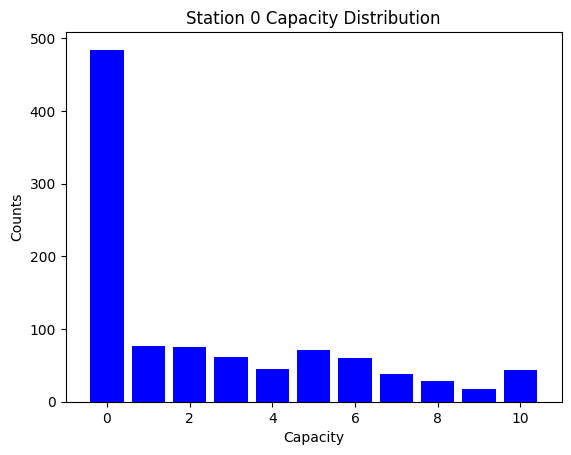

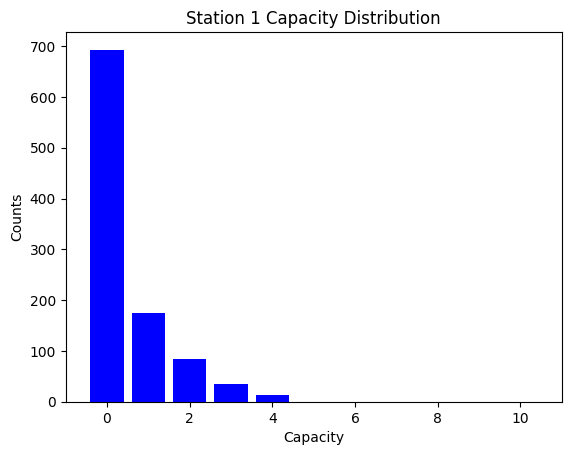

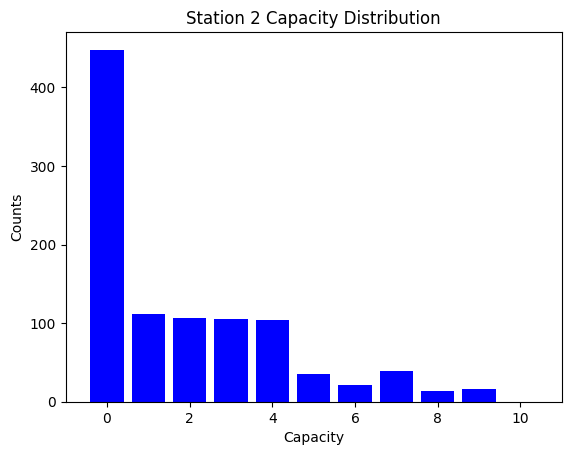

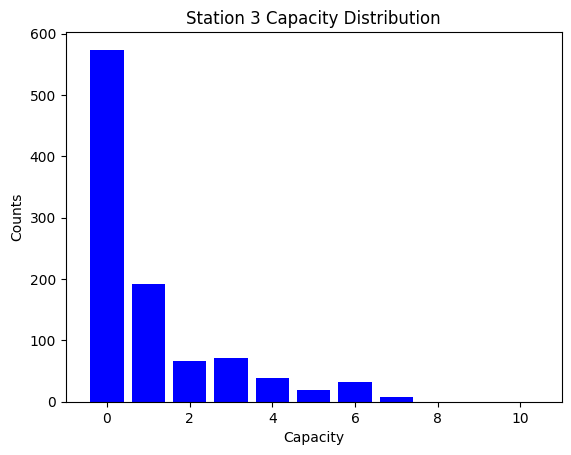

In [53]:
# anim.animate(agent_data)
station_bike_hist(agent_data)

## Optimization
The point of using agent based modelling is to be able to see if we can find an optimal placement of the stations that will minimize a specified fitness function. In our case, we will be looking to maximize the average number of trips completed by each agent.

We have two ways to optimize the placement of the stations:
1. Particle Swarm Optimization (PSO): This is a global optimization algorithm that is inspired by the social behavior of birds flocking or fish schooling. The algorithm is initialized with a population of random solutions and searches for optima by updating generations of solutions based on the best solutions found so far by the population as a whole, as well as the best solutions found in the particle's own history.
2. Genetic Algorithm (GA): This is a global optimization algorithm that is inspired by the process of natural selection. The algorithm is initialized with a population of random solutions and searches for optima by updating generations of solutions based on the two best solutions found in the current generation, then it randomly combines the two solutions to create children that are then randomly mutated from the parent solutions.

### Fitness Function

The fitness function we will use is the average number of trips completed by each agent. This is a good metric to use since it is a direct measure of the utility of the system. The more trips that are completed, the more useful the system is to the agents.

Since both the PSO and GA algorithms are designed to minimize a fitness function, we will simply take the negative of the average number of trips completed by each agent.

In [54]:
def fitness_from_coords(coordinate_list, agents, weights, seed=1, n_steps=1000):
    """
    Fitness function for the optimization problem, returns the negative of the average number of trips per agent

    Parameters:
    ---
    coordinate_list: dict
        Dictionary containing the coordinates of the stations and destinations
    agents: int
        Number of agents in the model
    weights: list
        List of weights for the destinations
    seed: int
        Random seed for the model
    n_steps: int
        Number of steps to run the model for

    Returns:
    ---
    float
        Negative of the average number of trips per agent
    """
    destinations = coordinate_list["destination"]
    stations = coordinate_list["station"]
    G, s, d = gu.create_graph_from_coordinates(stations, destinations)
    model = m.MyModel(agents, seed=seed, G=G, weights=weights)
    for i in range(n_steps):
        model.step()
    return -1*model.trips_average()

def fitness(agents, weights, seed=1, n_steps=1000):
    """
    Returns a lambda function that takes a list of coordinates and returns the fitness value. 
    Used as the fitness function for the optimizer class since it only accepts functions with 
    one parameter of destination coordinates

    Parameters:
    ---
    agents: int
        Number of agents in the model
    weights: list
        List of weights for the destinations
    seed: int
        Random seed for the model
    n_steps: int
        Number of steps to run the model for

    Returns:
    ---
    lambda
        Lambda function that takes a list of coordinates and returns the fitness value
    """
    return lambda x: fitness_from_coords(x, agents, weights, seed, n_steps)

### 2 Destination, 2 Station Example
The two destination and two station example is the simplest optimization problem to work with since the analytical solution is to simply place the stations at the destinations. In fact, this would be true for any case where the number of stations is equal to the number of destinations, and two stations is the smallest number of stations that makes sense to have in a system (only one station would require people to rent and park bikes at the same station).

When we initialize the optimization object, we pass in the hyperparameters for both the PSO and GA algorithms, the citymap, and the fitness function. We can then run the optimization algorithm and see the results. As we optimize the placement of the stations, we can see that the average number of trips completed by each agent in the best solution always increases. The theoretical best values is estimated by placing a station at each destination, and we see that the optimization algorithms are usually not able to find the best possible solution, but get reasonably close upon visual inspection.

{0: {'pos': (-4.5, 0), 'type': 'destination', 'data': None}, 1: {'pos': (4.5, 0), 'type': 'destination', 'data': None}}


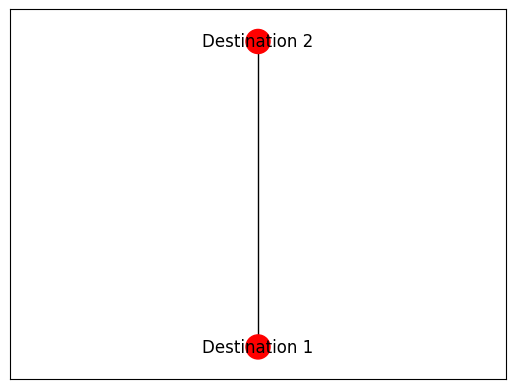

In [55]:
### map
destinations_coords = [
    (0, -4.5), 
    (0, 4.5), 
]

# weights for each destination (add up to 1)
w = [0.75, 0.25]

G,s,d = gu.create_graph_from_coordinates([], destinations_coords)

pos = {i: d["Destination " + str(i+1)] for i in range(len(d))}
print(pos)
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw_networkx(G, {"Destination 1": [0, -4.5], "Destination 2": [0, 4.5]}, node_color = colors, with_labels=True)

Theoretical best: -4.5


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -3.0
Iteration 10: Best fitness: -3.1
Iteration 20: Best fitness: -3.3
Iteration 30: Best fitness: -3.9
Iteration 40: Best fitness: -3.9


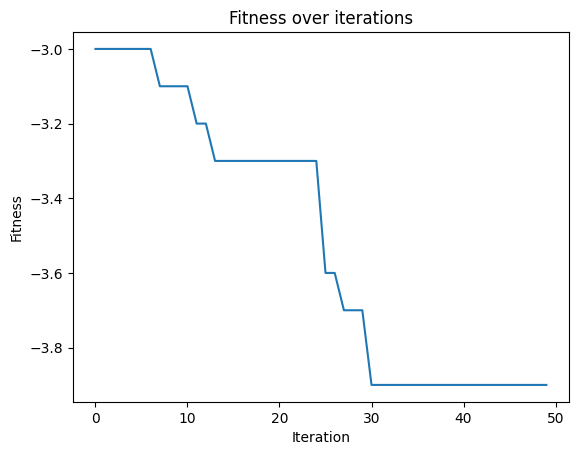

Best solution found: -3.9


In [56]:
citymap = [(-6,-6), (6,6)] + destinations_coords

print("Theoretical best:", fitness_from_coords(coordinate_list={"destination": destinations_coords, "station": destinations_coords}, agents=20, weights=w, seed=1, n_steps=100))

optimizer = ogf.Optimize(citymap, fitness(agents=20, weights=w, seed=1, n_steps=100), w=0.7, c1=1.4, c2=1.4, mutation_rate=0.7, alpha=0.3)
bestpos, bestfit = optimizer.optimize_PSO(20, 2, 50)

## uncomment for genetic algorithm
# bestpos, bestfit = optimizer.optimize_genetic(num_particles=20, num_dimensions=2, num_iterations=50) 

optimizer.plot_losses()
print("Best solution found:", bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
# print(stations)
G, s, d, = gu.create_graph_from_coordinates(stations, destinations_coords)

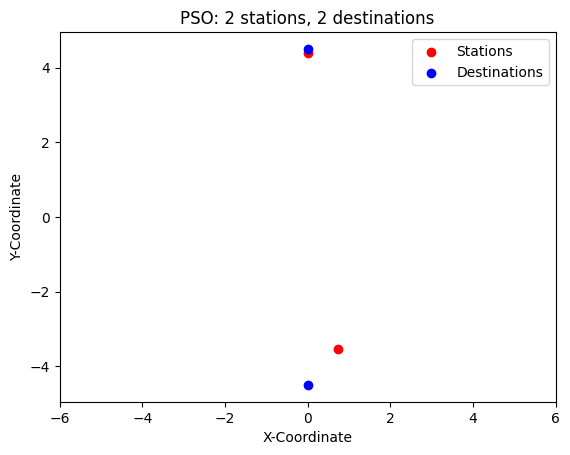

In [57]:
plt.scatter([station[0] for station in stations], [station[1] for station in stations], c='red', label='Stations')
plt.scatter([destination[0] for destination in destinations_coords], [destination[1] for destination in destinations_coords], c='blue', label='Destinations')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.xlim(-6, 6)

plt.title('PSO: 2 stations, 2 destinations')
plt.legend()
# plt.savefig('PSO_2_2_2weight.png')
plt.show()

### 4 destinations, 2 stations example
Follows the same logic as before, but will change some parameters for additional destinations. We will place the destinations along a diamond shape, and two destinations will be farther apart than the other two. By doing this, we should expect the optimal solution to have the stations placed at the two destinations that are farther apart rather than the two destinations that are closer together.

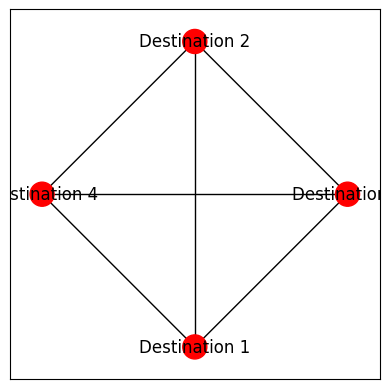

In [58]:
### parameters
destinations_coords = [
    (0, -8), 
    (0, 8), 
    (4.5,0),
    (-4.5,0)
]

# weights for each destination (add up to 1)
w = [0.25,0.25,0.25,0.25]

G,s,d = gu.create_graph_from_coordinates([], destinations_coords)

pos = {i: d["Destination " + str(i+1)] for i in range(len(d))}
# print(pos)
colors = ['r' if G.nodes[i]['type'] == 'destination' else 'b' for i in G.nodes]
nx.draw_networkx(G, {"Destination 1": [0, -4.5], "Destination 2": [0, 4.5], "Destination 3": [4.5, 0], "Destination 4": [-4.5,0]}, node_color = colors, with_labels=True)
plt.gca().set_aspect('equal', adjustable='box')

Theoretical best: -5.05


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -2.7
Iteration 10: Best fitness: -3.0
Iteration 20: Best fitness: -3.0
Iteration 30: Best fitness: -3.0
Iteration 40: Best fitness: -3.0


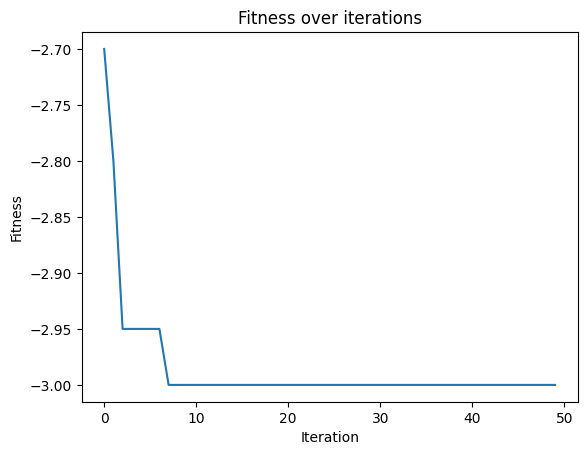

Best solution found: -3.0


In [59]:
citymap = [(-10,-10), (10,10)] + destinations_coords

print("Theoretical best:", fitness_from_coords({"destination": destinations_coords, "station": destinations_coords}, agents=20, weights=w, seed=1, n_steps=100))

optimizer = ogf.Optimize(citymap, fitness(agents=20, weights=w, seed=1, n_steps=100), 0.7, 1.4, 1.4)
bestpos, bestfit = optimizer.optimize_PSO(20, 2, 50)

## uncomment for genetic algorithm
# bestpos, bestfit = optimizer.optimize_genetic(20, 2, 50) 

optimizer.plot_losses()
print("Best solution found:", bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
# print(stations)
G, s, d, = gu.create_graph_from_coordinates(stations, destinations_coords)

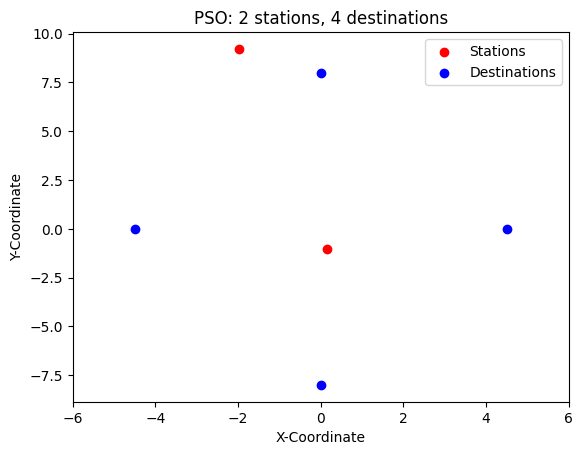

In [60]:
plt.scatter([station[0] for station in stations], [station[1] for station in stations], c='red', label='Stations')
plt.scatter([destination[0] for destination in destinations_coords], [destination[1] for destination in destinations_coords], c='blue', label='Destinations')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.xlim(-6, 6)

plt.title('PSO: 2 stations, 4 destinations')
plt.legend()
# plt.savefig('PSO_2_2_2weight.png')
# plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# UT map optimization

Since we see that the optimization works as expected, lets try to optimize the placement of the stations on the UT map. We will use the UT map data and station data to run the optimization algorithm and see if we can find a better placement of the stations than the current placement.

`destination_coords` comes from selecting particular locations of interest on the UT map, and `gu.ut_weights()` comes from the `graph_utils.py` file, which is used to get the weights for the probability distribution of destinations for the commuters which was obtained through looking at metrobike data.

Additionally, we see that both PSO and GA produce different results for the UT map optimization problem, whereas they generally agreed for the simpler cases tested above.

One constraint we placed on the problem is to only look for solutions to when the number of stations to place is less than or equal to the number of destinations. This is because the solution to an equal number of stations and destinations is trivial, and also we found that both PSO and GA perform very poorly when the number of stations is equal to the number of destinations.

Average edge length (TOTAL): 5.284430560802597
Minimum edge length (TOTAL): 0.9316949906211162
Maximum edge length (TOTAL): 10.906165432654499


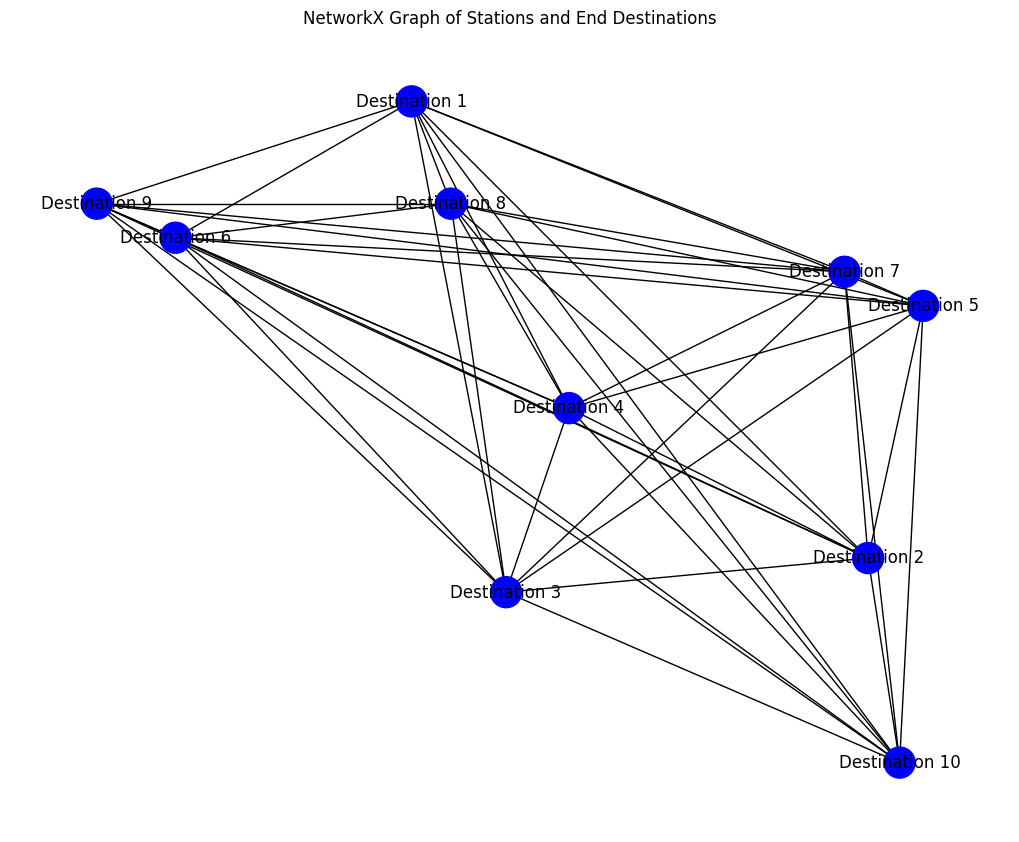

In [61]:
destinations_coords = [(3.2768939393972687, -1.4515151515224716), 
                     (-2.306439393934852, 3.381818181806011), 
                     (-2.7231060606027313, -0.45151515152247157), 
                     (-0.4731060606027313, 0.21515151514904574), 
                     (0.7768939393972687, 3.965151515134494), 
                     (1.6102272727293894, -3.9515151515224716), 
                     (1.193560606065148, 3.131818181806011), 
                     (2.0268939393972687, -1.0348484848655062), 
                     (2.0268939393972687, -4.784848484850954), 
                     (-4.806439393934852, 3.7151515151490457)]

# Usage after creating the graph
G, station_nodes, end_destination_nodes = gu.create_graph_from_coordinates([], destinations_coords)
average_edge_length = gu.calculate_average_edge_length(G)
min_edge_length = gu.calculate_minimum_edge_length(G)
max_edge_length = gu.calculate_maximum_edge_length(G)

print(f"Average edge length (TOTAL): {average_edge_length}")
print(f"Minimum edge length (TOTAL): {min_edge_length}")
print(f"Maximum edge length (TOTAL): {max_edge_length}")

pos = nx.get_node_attributes(G, 'pos')

node_colors = ['red' if G.nodes[node]['type'] == 'station' else 'blue' for node in G.nodes]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors)
plt.title("NetworkX Graph of Stations and End Destinations")
plt.show()

Theoretical best: -8.82


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -6.2
Iteration 10: Best fitness: -6.3
Iteration 20: Best fitness: -6.3
Iteration 30: Best fitness: -6.38
Iteration 40: Best fitness: -6.42


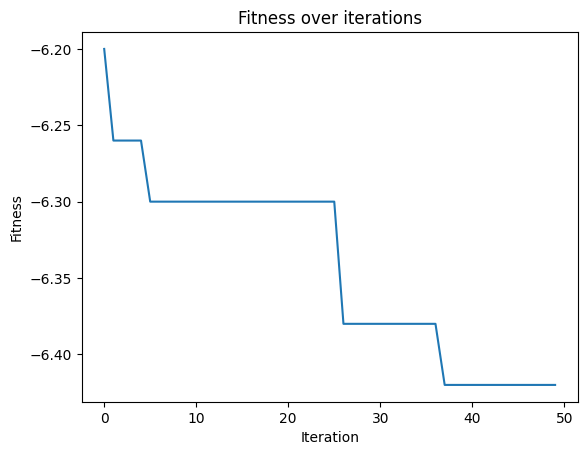

Best solution found: -6.42


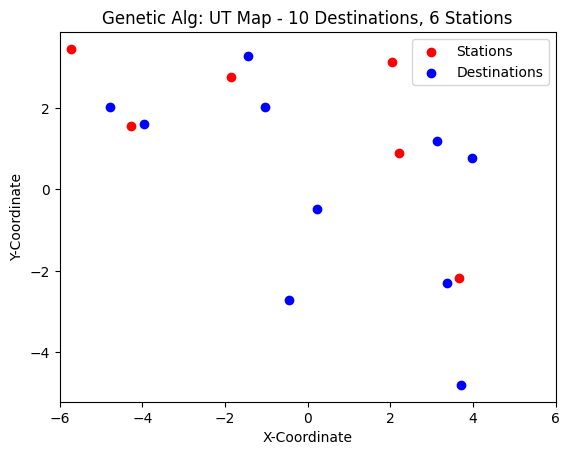

In [62]:
citymap = [(-6,-6), (6,6)] + destinations_coords
w = gu.ut_weights()

print("Theoretical best:", fitness_from_coords({"destination": destinations_coords, "station": destinations_coords}, agents=50, weights=w, seed=1, n_steps=100))

optimizer = ogf.Optimize(citymap, fitness(agents=50,weights=w,seed=1,n_steps=100), 0.7, 1.4, 1.4)
bestpos, bestfit = optimizer.optimize_genetic(20, 6, 50)

optimizer.plot_losses()
print("Best solution found:", bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
# print(stations)
G, s, d, = gu.create_graph_from_coordinates(stations, destinations_coords)
# print(bestpos)

plt.scatter([station[1] for station in stations], [station[0] for station in stations], c='red', label='Stations')
plt.scatter([destination[1] for destination in destinations_coords], [destination[0] for destination in destinations_coords], c='blue', label='Destinations')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.xlim(-6,6)

plt.title('Genetic Alg: UT Map - 10 Destinations, 6 Stations')
plt.legend()
plt.show()

Theoretical best: -8.82


  0%|          | 0/50 [00:00<?, ?it/s]

Iteration 0: Best fitness: -6.08
Iteration 10: Best fitness: -6.1
Iteration 20: Best fitness: -6.22
Iteration 30: Best fitness: -6.26
Iteration 40: Best fitness: -6.26


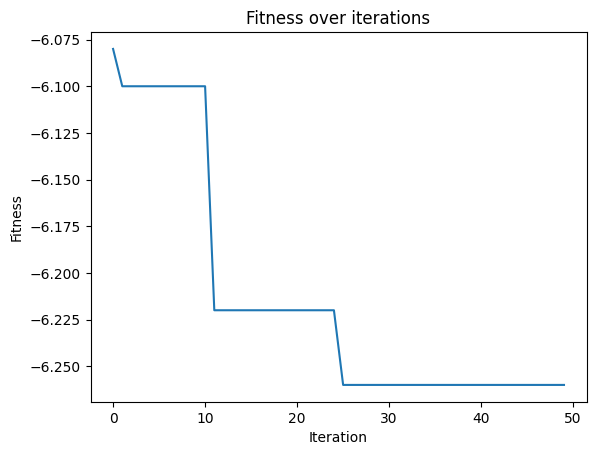

Best solution found: -6.26


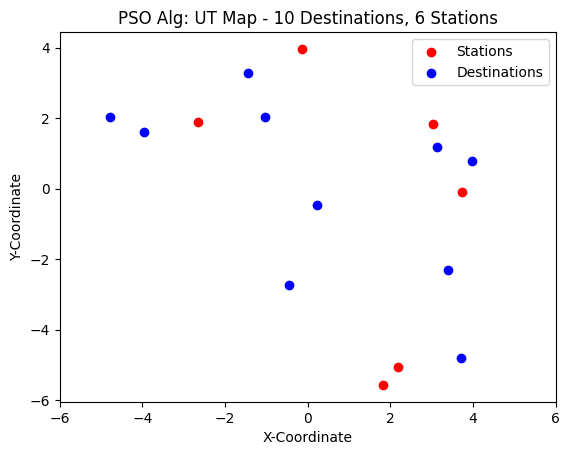

In [63]:
print("Theoretical best:", fitness_from_coords({"destination": destinations_coords, "station": destinations_coords}, agents=50, weights=w, seed=1, n_steps=100))

optimizer = ogf.Optimize(citymap, fitness(agents=50, weights=w, seed=1, n_steps=100), 0.7, 1.4, 1.4)
bestpos, bestfit = optimizer.optimize_PSO(20, 6, 50)
optimizer.plot_losses()
print("Best solution found:", bestfit)
stations = [(bestpos[i], bestpos[i+1]) for i in range(0, len(bestpos), 2)]
# print(stations)
G, s, d, = gu.create_graph_from_coordinates(stations, destinations_coords)
# print(bestpos)

plt.scatter([station[1] for station in stations], [station[0] for station in stations], c='red', label='Stations')
plt.scatter([destination[1] for destination in destinations_coords], [destination[0] for destination in destinations_coords], c='blue', label='Destinations')
plt.xlabel('X-Coordinate')
plt.ylabel('Y-Coordinate')
plt.xlim(-6, 6)

plt.title('PSO Alg: UT Map - 10 Destinations, 6 Stations')
plt.legend()
plt.show()